# RT1-P1 Element for Poisson Equation in 2D

This example is to show the rate of convergence of the RT1-P1 mixed finite element approximation of the Poisson equation on the unit square:

$$- \nabla (d \nabla) u = f \; \hbox{in } (0,1)^2$$

for the following boundary conditions
- pure Dirichlet boundary condition: $u = g_D \text{ on } \partial \Omega$.
- Pure Neumann boundary condition: $d\nabla u\cdot n=g_N \text{ on } \partial \Omega$.
- mixed boundary condition: $u=g_D \text{ on }\Gamma_D, \nabla u\cdot n=g_N \text{ on }\Gamma_N.$

Find $(\sigma , u)$ in $H_{g_N,\Gamma_N}(div,\Omega)\times L^2(\Omega)$ s.t. 

$$ (d^{-1}\sigma,\tau) + (div \tau, u)  = \langle \tau \cdot n, g_D \rangle_{\Gamma_D} \quad \forall \tau \in H_{0,\Gamma_N}(div,\Omega)$$

$$ (div \sigma, v)                =  -(f,v) \quad \forall v \in L^2(\Omega) $$
 
 where 
 
 $$H_{g,\Gamma}(div,\Omega) = \{\sigma \in H(div,\Omega); \sigma \cdot n = g  \text{ on } \Gamma \subset \partial\Omega \}.$$

 The unknown $\sigma = d\nabla u$ is approximated using the incomplete P2 Raviart-Thomas element (RT1) and $u$ by piecewise constant element (P1). The expected convergence rate is 2nd order in H(div) and L2 norm for $\sigma$ and L2 norm of $u$. 

**References**
See page 12, Table 9.2. Arnold, Douglas N. and Falk, Richard S. and Winther, Ragnar. Geometric decompositions and local bases for spaces of finite element differential forms. Comput. Methods Appl. Mech. Engrg. 198():1660--1672, 2009.

**Subroutines**:

    - PoissonRT1
    - squarePoissonRT1
    - mfemPoisson
    - PoissonRT1mfemrate
    
The method is implemented in `PoissonRT1` subroutine and tested in `squarePoissonRT1`. Together with other elements (RT0, BDM1), `mfemPoisson` provides a concise interface to solve Poisson equation in mixed formulation. The RT0-P0 element is tested in `PoissonRT1mfemrate`. This doc is based on `PoissonRT1mfemrate`.    

## RT1 Incomplete Quadratic H(div) Element in 2D

We explain degree of freedoms and basis functions for RT1 element on a triangle. 

### Asecond orientation
The dofs and basis depends on the orientation of the mesh. We shall use the asecond orientation, i.e., `elem(t,1)< elem(t,2)< elem(t,3)` not the positive orientation. Given an `elem`, the asecond orientation can be constructed by 

        [elem,bdFlag] = sortelem(elem,bdFlag);  % ascend ordering
        
Note that `bdFlag` should be sorted as well. 

The local edge is also asecond `[2 3; 1 3; 1 2]` so that the local orientation is consistent with the global one and thus no need to deal with the sign difference when the positive oritentation is used. Read [Simplicial complex in two dimensions](../mesh/scdoc.html) for more discussion of indexing, ordering and orientation.

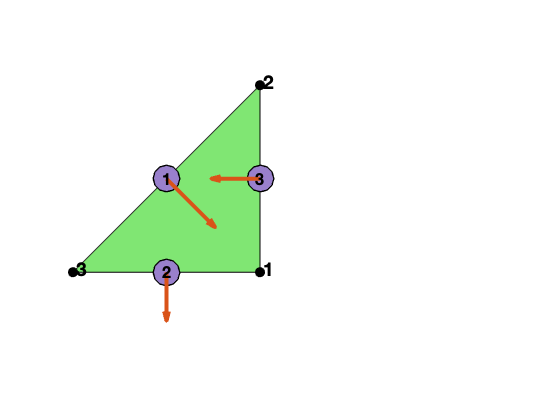

In [2]:
node = [1,0; 1,1; 0,0];
elem = [1 2 3];
edge = [2 3; 1 3; 1 2];
figure;
subplot(1,2,1)
showmesh(node,elem);
findnode(node);
findedge(node,edge,'all','rotvec');

### Local bases of RT1 element

Suppose `[i,j]` is the k-th edge. The two dimensional curl is a rotated graident defined as $\nabla^{\bot} f = (-\partial_y f, \partial _x f).$ For RT0, the basis of this edge along with its divergence are given by

$$ \phi_k = \lambda_i \nabla^{\bot} \lambda_j - \lambda_j \nabla^{\bot} \lambda_i. $$

For BDM1, one more basis is added on this edge

$$ \psi_k = \lambda_i \nabla^{\bot} \lambda_j + \lambda_j \nabla^{\bot} \lambda_i. $$

For RT1, two more bases are added to the triangle. Suppose $i,j,k$ are the vertices of the triangle and $i<j<k$. The two bases are

$$ \chi_1 = \lambda_j\phi _{ik} = \lambda_j(\lambda_i\nabla^{\bot} \lambda_k -
\lambda_k\nabla^{\bot}\lambda_i),\quad
   \chi_2 = \lambda_k\phi _{ij} = \lambda_k(\lambda_i\nabla^{\bot} \lambda_j -
\lambda_j\nabla^{\bot}\lambda_i).$$

Inside one triangle, we order the local bases in the following way: 

$$\{\phi_1,~\,\phi_2,~\,\phi_3,~\,\psi_1,~\,\psi_2,~\, \psi_3, ~\, \chi_1, ~\, \chi_2\}.$$

Note that $RT_0 \subset BDM_1 \subset RT_1$.

The first 3 dual bases are the line integral over orientated edges

$$d_i^{\phi}(u) = \int_{e_i} u \cdot n_i \, ds,$$

and the second 3 dual bases are

$$d_{ij}^{\psi}(u) = 3 \int_{e_{i, j}} \boldsymbol{u} \cdot \boldsymbol{n}_{i, j}\left(\lambda_{i}-\lambda_{j}\right) \, ds,$$

where $n_i = t_i^{\bot}$ is the rotation of the unit tangential vector of $e_i$ by $90^{\deg}$ counterclockwise. Note that both the bases and the dual bases depend on the orientation of the edge not necessiliarly couterclockwise.

It is straightforward to verify the "orthogonality":
$$d^{\phi}(\psi) = 0, \quad d^{\psi}(\phi) = 0, \quad d_i^{\phi}(\phi_j) = \delta_{ij}, \quad  d_i^{\psi}(\psi_j) = \delta_{ij}.$$

But it is diffcult to find the "orthogonal" dual basis for $\chi_1,\chi_2$. One choice is $$l_f^1(u) := \int_{T} u\cdot n_{ik}\, dx, \quad l_f^2(u) := \int_{T} u\cdot n_{ij}\, dx.$$ Then $l_f(\phi) \neq 0, l_f(\psi) \neq 0$. The good news is $d_e^{\phi}(\chi) = d_e^{\psi}(\chi) = 0$ as $\lambda_k\phi _{ij}\cdot n_e = 0$ either $\lambda_k|e = 0$ or $\phi_{ij}\cdot n_e = 0$. 

We need to solve a small system to get the coefficients for bases $\chi$. Fortunately this has been done in quadratic H(curl) element. More precisely, suppose $$u=\sum \alpha_{i} \phi_{i}+\sum \beta_{j} \psi_{j}+\sum \gamma_{k} x_{k}$$

The interpolation is implemented in `faceinterpolate`.

### Local to global index map

Three local edges are `locEdge = [2 3; 1 3; 1 2]`. The pointer from the local to global index can be constructured by

    [elem2edge,edge] = dofedge(elem);


elem2edge =

  8�3 uint32 matrix

    8    3    2
   11    6    5
   15   10    9
   16   13   12
    5    3    1
    7    6    4
   12   10    8
   14   13   11



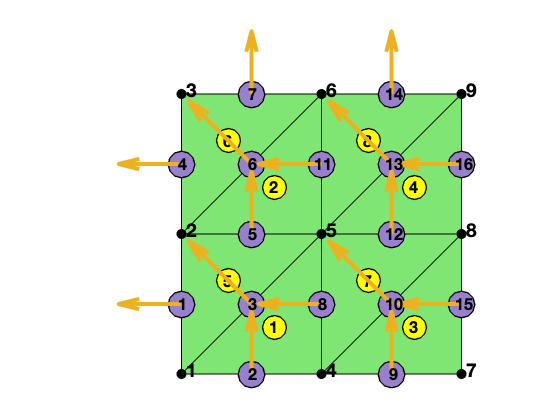

In [3]:
[node,elem] = squaremesh([0 1 0 1], 0.5);
bdFlag = setboundary(node,elem,'Dirichlet');
[elem,bdFlag] = sortelem(elem,bdFlag);
showmesh(node,elem);
findnode(node);
findelem(node,elem);
[elem2edge,edge] = dofedge(elem);
findedge(node,edge,'all','rotvec');
display(elem2edge);

## Assembling the matrix equation

We discuss several issues in the assembling.

### Mass matrix

The mass matrix can be computed by

    M = getmassmatvec(elem2edge,area,Dlambda,'RT1');